# Task - Train a deep learning model

# Suggested Data:
IMDB movies reviews from kaggle

# Deliverables:
Simple LSTM using PyTorch

Classify the movies based on reviews

### ----------------------------------------------------------------------------------------------------------------------------------

### Import the basic libraries.

In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


### Load the dataset.


In [4]:
df = pd.read_csv('IMDB Dataset.csv')

In [6]:
df.head()

,review,length of text,sentiment
0,Match 1: Tag Team Table Match Bubba Ray and Sp...,13704,positive
1,There's a sign on The Lost Highway that says:<...,12988,positive
2,"(Some spoilers included:)<br /><br />Although,...",12930,positive
3,"Back in the mid/late 80s, an OAV anime by titl...",12129,positive
4,**Attention Spoilers**<br /><br />First of all...,10363,positive


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          50000 non-null  object
 1   length of text  50000 non-null  int64 
 2   sentiment       50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [11]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

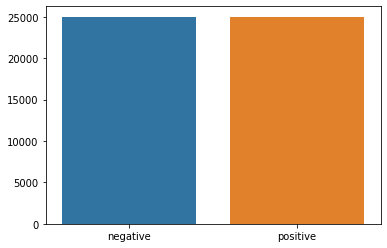

In [30]:
dd = pd.Series(df['sentiment']).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Let's take one review as sample and understand why we need to clean the text.

In [32]:
review = df['review'].loc[1]
review

'There\'s a sign on The Lost Highway that says:<br /><br />*MAJOR SPOILERS AHEAD*<br /><br />(but you already knew that, didn\'t you?)<br /><br />Since there\'s a great deal of people that apparently did not get the point of this movie, I\'d like to contribute my interpretation of why the plot makes perfect sense. As others have pointed out, one single viewing of this movie is not sufficient. If you have the DVD of MD, you can "cheat" by looking at David Lynch\'s "Top 10 Hints to Unlocking MD" (but only upon second or third viewing, please.) ;)<br /><br />First of all, Mulholland Drive is downright brilliant. A masterpiece. This is the kind of movie that refuse to leave your head. Not often are the comments on the DVDs very accurate, but Vogue\'s "It gets inside your head and stays there" really hit the mark.<br /><br />David Lynch deserves praise for creating a movie that not only has a beautifully stylish look to it - cinematography-wise, has great acting (esp. Naomi Watts), a haunti

### Remove all non-word characters (everything except numbers and letters)

In [38]:
review = re.sub(r"[^\w\s]", '', review)
review

'TheresasignonTheLostHighwaythatsaysbrbrMAJORSPOILERSAHEADbrbrbutyoualreadyknewthatdidntyoubrbrSincetheresagreatdealofpeoplethatapparentlydidnotgetthepointofthismovieIdliketocontributemyinterpretationofwhytheplotmakesperfectsenseAsothershavepointedoutonesingleviewingofthismovieisnotsufficientIfyouhavetheDVDofMDyoucancheatbylookingatDavidLynchsTopHintstoUnlockingMDbutonlyuponsecondorthirdviewingpleasebrbrFirstofallMulhollandDriveisdownrightbrilliantAmasterpieceThisisthekindofmoviethatrefusetoleaveyourheadNotoftenarethecommentsontheDVDsveryaccuratebutVoguesItgetsinsideyourheadandstaystherereallyhitthemarkbrbrDavidLynchdeservespraiseforcreatingamoviethatnotonlyhasabeautifullystylishlooktoitcinematographywisehasgreatactingespNaomiWattsahauntingsoundtrackbyBadalamentiandaverydreamlikequalitytoitbutontopofitallitalsomanagestoinvolvetheviewerinsuchawaythatfewmovieshavebeforeAfterallwhenisthelasttimeyousawamoviethatjustwouldntleaveyourmindandthateveryonefeltcompelledtotalkandwriteaboutregardle

### Replace all runs of whitespaces with no space

In [39]:
review = re.sub(r"\s+", '', review)
review

'TheresasignonTheLostHighwaythatsaysbrbrMAJORSPOILERSAHEADbrbrbutyoualreadyknewthatdidntyoubrbrSincetheresagreatdealofpeoplethatapparentlydidnotgetthepointofthismovieIdliketocontributemyinterpretationofwhytheplotmakesperfectsenseAsothershavepointedoutonesingleviewingofthismovieisnotsufficientIfyouhavetheDVDofMDyoucancheatbylookingatDavidLynchsTopHintstoUnlockingMDbutonlyuponsecondorthirdviewingpleasebrbrFirstofallMulhollandDriveisdownrightbrilliantAmasterpieceThisisthekindofmoviethatrefusetoleaveyourheadNotoftenarethecommentsontheDVDsveryaccuratebutVoguesItgetsinsideyourheadandstaystherereallyhitthemarkbrbrDavidLynchdeservespraiseforcreatingamoviethatnotonlyhasabeautifullystylishlooktoitcinematographywisehasgreatactingespNaomiWattsahauntingsoundtrackbyBadalamentiandaverydreamlikequalitytoitbutontopofitallitalsomanagestoinvolvetheviewerinsuchawaythatfewmovieshavebeforeAfterallwhenisthelasttimeyousawamoviethatjustwouldntleaveyourmindandthateveryonefeltcompelledtotalkandwriteaboutregardle

### Replace digits with no space

In [40]:
review = re.sub(r"\d", '', review)
review

'TheresasignonTheLostHighwaythatsaysbrbrMAJORSPOILERSAHEADbrbrbutyoualreadyknewthatdidntyoubrbrSincetheresagreatdealofpeoplethatapparentlydidnotgetthepointofthismovieIdliketocontributemyinterpretationofwhytheplotmakesperfectsenseAsothershavepointedoutonesingleviewingofthismovieisnotsufficientIfyouhavetheDVDofMDyoucancheatbylookingatDavidLynchsTopHintstoUnlockingMDbutonlyuponsecondorthirdviewingpleasebrbrFirstofallMulhollandDriveisdownrightbrilliantAmasterpieceThisisthekindofmoviethatrefusetoleaveyourheadNotoftenarethecommentsontheDVDsveryaccuratebutVoguesItgetsinsideyourheadandstaystherereallyhitthemarkbrbrDavidLynchdeservespraiseforcreatingamoviethatnotonlyhasabeautifullystylishlooktoitcinematographywisehasgreatactingespNaomiWattsahauntingsoundtrackbyBadalamentiandaverydreamlikequalitytoitbutontopofitallitalsomanagestoinvolvetheviewerinsuchawaythatfewmovieshavebeforeAfterallwhenisthelasttimeyousawamoviethatjustwouldntleaveyourmindandthateveryonefeltcompelledtotalkandwriteaboutregardle

### Next we will bring everything into lowercase.

In [41]:
review = review.lower()
review

'theresasignonthelosthighwaythatsaysbrbrmajorspoilersaheadbrbrbutyoualreadyknewthatdidntyoubrbrsincetheresagreatdealofpeoplethatapparentlydidnotgetthepointofthismovieidliketocontributemyinterpretationofwhytheplotmakesperfectsenseasothershavepointedoutonesingleviewingofthismovieisnotsufficientifyouhavethedvdofmdyoucancheatbylookingatdavidlynchstophintstounlockingmdbutonlyuponsecondorthirdviewingpleasebrbrfirstofallmulhollanddriveisdownrightbrilliantamasterpiecethisisthekindofmoviethatrefusetoleaveyourheadnotoftenarethecommentsonthedvdsveryaccuratebutvoguesitgetsinsideyourheadandstaystherereallyhitthemarkbrbrdavidlynchdeservespraiseforcreatingamoviethatnotonlyhasabeautifullystylishlooktoitcinematographywisehasgreatactingespnaomiwattsahauntingsoundtrackbybadalamentiandaverydreamlikequalitytoitbutontopofitallitalsomanagestoinvolvetheviewerinsuchawaythatfewmovieshavebeforeafterallwhenisthelasttimeyousawamoviethatjustwouldntleaveyourmindandthateveryonefeltcompelledtotalkandwriteaboutregardle

### Stopwords removal - since stopwords removal works on every word in your text we need to split the text.

In [42]:
review = review.split()
review

['theresasignonthelosthighwaythatsaysbrbrmajorspoilersaheadbrbrbutyoualreadyknewthatdidntyoubrbrsincetheresagreatdealofpeoplethatapparentlydidnotgetthepointofthismovieidliketocontributemyinterpretationofwhytheplotmakesperfectsenseasothershavepointedoutonesingleviewingofthismovieisnotsufficientifyouhavethedvdofmdyoucancheatbylookingatdavidlynchstophintstounlockingmdbutonlyuponsecondorthirdviewingpleasebrbrfirstofallmulhollanddriveisdownrightbrilliantamasterpiecethisisthekindofmoviethatrefusetoleaveyourheadnotoftenarethecommentsonthedvdsveryaccuratebutvoguesitgetsinsideyourheadandstaystherereallyhitthemarkbrbrdavidlynchdeservespraiseforcreatingamoviethatnotonlyhasabeautifullystylishlooktoitcinematographywisehasgreatactingespnaomiwattsahauntingsoundtrackbybadalamentiandaverydreamlikequalitytoitbutontopofitallitalsomanagestoinvolvetheviewerinsuchawaythatfewmovieshavebeforeafterallwhenisthelasttimeyousawamoviethatjustwouldntleaveyourmindandthateveryonefeltcompelledtotalkandwriteaboutregardl

In [43]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

review = [word for word in review if not word in set(stopwords.words('english'))]
review

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumil0257/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['theresasignonthelosthighwaythatsaysbrbrmajorspoilersaheadbrbrbutyoualreadyknewthatdidntyoubrbrsincetheresagreatdealofpeoplethatapparentlydidnotgetthepointofthismovieidliketocontributemyinterpretationofwhytheplotmakesperfectsenseasothershavepointedoutonesingleviewingofthismovieisnotsufficientifyouhavethedvdofmdyoucancheatbylookingatdavidlynchstophintstounlockingmdbutonlyuponsecondorthirdviewingpleasebrbrfirstofallmulhollanddriveisdownrightbrilliantamasterpiecethisisthekindofmoviethatrefusetoleaveyourheadnotoftenarethecommentsonthedvdsveryaccuratebutvoguesitgetsinsideyourheadandstaystherereallyhitthemarkbrbrdavidlynchdeservespraiseforcreatingamoviethatnotonlyhasabeautifullystylishlooktoitcinematographywisehasgreatactingespnaomiwattsahauntingsoundtrackbybadalamentiandaverydreamlikequalitytoitbutontopofitallitalsomanagestoinvolvetheviewerinsuchawaythatfewmovieshavebeforeafterallwhenisthelasttimeyousawamoviethatjustwouldntleaveyourmindandthateveryonefeltcompelledtotalkandwriteaboutregardl

### Splitting to train and test data.

In [7]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


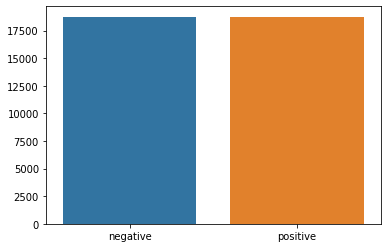

In [8]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Clean the text and build the train and test corpus.

### Tokenization

In [12]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
        final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
        final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()  if preprocess_string(word) in onehot_dict.keys()])
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [13]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)


In [14]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

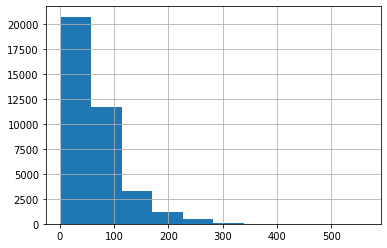

count    37500.000000
mean        69.429707
std         48.124434
min          2.000000
25%         39.000000
50%         54.000000
75%         85.000000
max        563.000000
dtype: float64

In [15]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

#### Observations :

a) Mean review length = around 69.

b) minimum length of reviews is 2.

c)There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis.

### Padding

Now we will pad each of the sequence to max length

In [17]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [18]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

### Batching and loading as tensor

In [19]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [20]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   4, 438, 241],
        [  0,   0,   0,  ..., 108, 226, 105],
        [  0,   0,   0,  ...,   2, 154, 741],
        ...,
        [  0,   0,   0,  ..., 674,  80, 108],
        [  0,   0,   0,  ..., 160, 373,   2],
        [  0,   0,   0,  ...,  73, 276, 419]])
Sample input: 
 tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table.

### Model

In [21]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [22]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training the model

In [23]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [27]:
from tqdm import tqdm

In [28]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in tqdm(range(epochs)):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in tqdm(train_loader):
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in tqdm(valid_loader):
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc += accuracy
    
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
#     if epoch_val_loss <= valid_loss_min:
#         torch.save(model.state_dict(), '../working/state_dict.pt')
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
#         valid_loss_min = epoch_val_loss
    print(25*'==')

100%|██████████| 750/750 [9:30:39<00:00, 45.65s/it]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.3949625978867213 val_loss : 0.3538843261599541
train_accuracy : 83.37866666666667 val_accuracy : 84.688



100%|██████████| 750/750 [30:42<00:00,  2.46s/it]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.35090489504734673 val_loss : 0.3555946469306946
train_accuracy : 85.43733333333333 val_accuracy : 84.616



100%|██████████| 750/750 [26:40<00:00,  2.13s/it]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.3115339372853438 val_loss : 0.332084754049778
train_accuracy : 87.02666666666666 val_accuracy : 85.592



100%|██████████| 750/750 [28:23<00:00,  2.27s/it]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.289858620117108 val_loss : 0.3293842121362686
train_accuracy : 88.04533333333333 val_accuracy : 85.568



100%|██████████| 750/750 [26:25<00:00,  2.11s/it]

100%|██████████| 5/5 [11:41:21<00:00, 8416.23s/it]   

Epoch 5
train_loss : 0.24825226439535616 val_loss : 0.3389814310371876
train_accuracy : 89.84 val_accuracy : 85.912


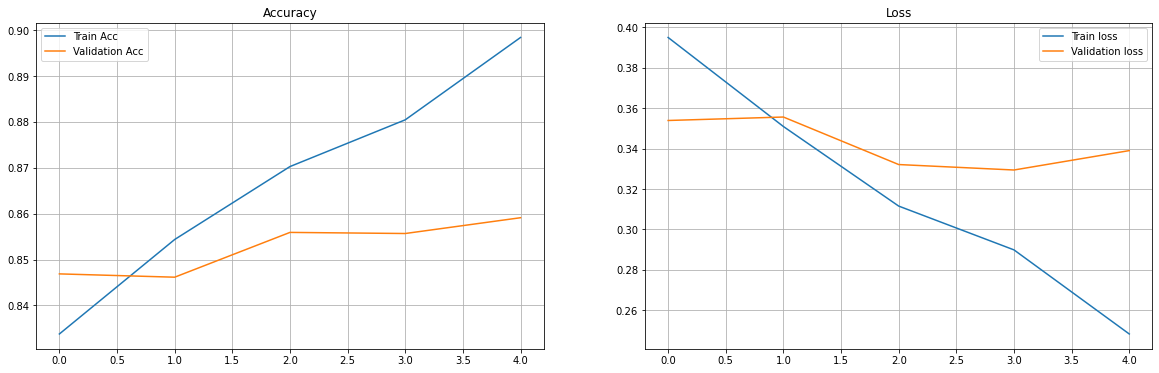

In [29]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Inference

In [44]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [45]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Possible Spoilers As Peter Jackson has so brilliantly shown in his `Lord of the Rings' trilogy, it is quite possible to make good films, even great ones, within the heroic fantasy genre. The genre has distinguished literary antecedents, dating back to the mediaeval chivalric romances, particularly the Arthurian legends, upon which Tolkien and other authors have drawn. `Lord of the Rings' apart, however, it is difficult to think of any other sword-and-sorcery films which are any good. I would agree with the reviewer who said that the best of a bad bunch was Ron Howard's `Willow', and even that achieved little distinction other than that of being a merely mediocre film as opposed to a positively bad one. `Red Sonja', however, cannot achieve the even more modest distinction of being simply a bad film as opposed to an appalling one.<br /><br />As with `Willow', many of the plot-elements in `Red Sonja' are derived from `The Lord of the Rings'. An evil ruler seeks to gain control of an artef

In [46]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

Without question, film is a powerful medium, more so now than ever before, due to the accessibility of DVD/video, which gives the filmmaker the added assurance that his story or message is going to be seen by possibly millions of people. Use of this medium, therefore, attaches an innate responsibility to the artist, inasmuch as film can be educational, as well as entertaining, which dictates that certain subjects should be approached accordingly and with a corresponding sensitivity and sensibility. A film like Spielberg's `Schindler's List,' for example, is important, in that it keeps alive the memory of that which must not be forgotten, and as history tends to repeat itself, Spielberg's film can be viewed as a valuable tool in preventing a recurrence of that tragedy. In that same vein, this film, `Focus,' directed by Neal Slavin, is important, in it illuminates the problematic reality of anti-Semitism, which for years beyond number has affected millions of people, is still unimaginabl